<a href="https://colab.research.google.com/github/nannahyo/test/blob/main/StyleCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-l47ol7tg
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-l47ol7tg
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=352f56c3b1f022a08d4eb0572c88fba98c8f58c6407ad3374ed4adb493301e55
  Stored in directory: /tmp/pip-ephem-wheel-cache-fbcs0rs7/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [ ]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

Cloning into 'StyleCLIP-Tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 19), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.
/content/StyleCLIP-Tutorial


In [ ]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2022-11-07 08:46:33--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1 [following]
--2022-11-07 08:46:34--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 381462551 (364M) [application/octet-stream]
Saving to: ‘stylegan2-ffhq-config-f.pt’

stylegan2-ffhq-conf 100%[===================>] 363.79M  68.3MB/s    in 9.7s    

2022-11-07 08:46:44 (37.4

In [ ]:
import torch
from stylegan2.model import Generator


g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()

In [ ]:
import clip


class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


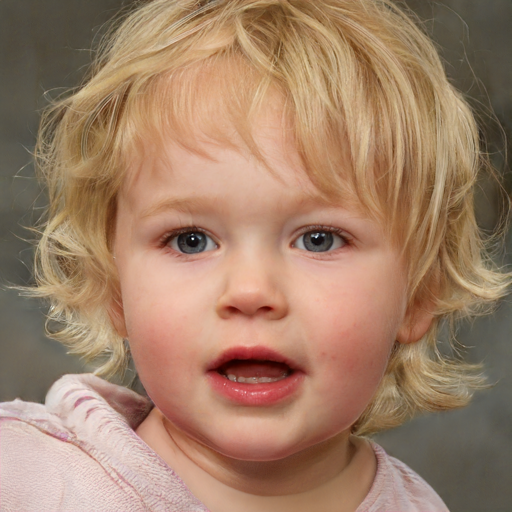

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


mean_latent = g_ema.mean_latent(4096)

latent_code_init_not_trunc = torch.randn(1, 512).cuda()
with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=0.7, truncation_latent=mean_latent)

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = image.size
image.resize((h // 2, w // 2))

In [ ]:
from argparse import Namespace


args = Namespace()
args.description = 'A really sad face'
args.lr_rampup = 0.05
args.lr = 0.1
args.step = 150
args.l2_lambda = 0.005 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir = 'results'

In [ ]:
import os
import math
import torchvision
from torch import optim


# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir, exist_ok=True)

# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)

for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True, range=(-1, 1))

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 179MiB/s]


lr: 0.0, loss: 0.7651
lr: 0.013333333333333334, loss: 0.7646
lr: 0.02666666666666667, loss: 0.7593
lr: 0.04, loss: 0.7666
lr: 0.05333333333333334, loss: 0.7827
lr: 0.06666666666666667, loss: 0.7783
lr: 0.08, loss: 0.7759
lr: 0.09333333333333334, loss: 0.7788
lr: 0.1, loss: 0.7754
lr: 0.1, loss: 0.7759
lr: 0.1, loss: 0.7881
lr: 0.1, loss: 0.7832
lr: 0.1, loss: 0.7812
lr: 0.1, loss: 0.7788
lr: 0.1, loss: 0.7798
lr: 0.1, loss: 0.7803
lr: 0.1, loss: 0.7827
lr: 0.1, loss: 0.7764
lr: 0.1, loss: 0.7705
lr: 0.1, loss: 0.7666
lr: 0.1, loss: 0.7700
lr: 0.1, loss: 0.7666
lr: 0.1, loss: 0.7681
lr: 0.1, loss: 0.7622
lr: 0.1, loss: 0.7603
lr: 0.1, loss: 0.7607
lr: 0.1, loss: 0.7603
lr: 0.1, loss: 0.7603
lr: 0.1, loss: 0.7578
lr: 0.1, loss: 0.7573
lr: 0.1, loss: 0.7549
lr: 0.1, loss: 0.7524
lr: 0.1, loss: 0.7539
lr: 0.1, loss: 0.7539
lr: 0.1, loss: 0.7534
lr: 0.1, loss: 0.7524
lr: 0.1, loss: 0.7510
lr: 0.1, loss: 0.7500
lr: 0.1, loss: 0.7500
lr: 0.1, loss: 0.7480
lr: 0.1, loss: 0.7466
lr: 0.1, loss: 

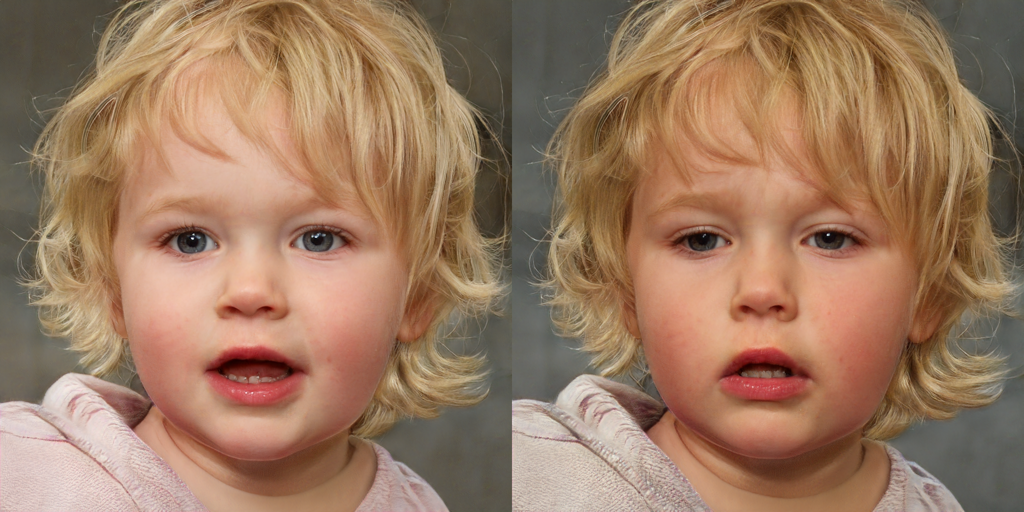

In [ ]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))

In [ ]:
!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>